In [1]:
!pip install apyori

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5956 sha256=b25db92742443e6b16a835c86c56ec2104f4902cefffa5e7bfd19ce6b2c66af0
  Stored in directory: /root/.cache/pip/wheels/c4/1a/79/20f55c470a50bb3702a8cb7c94d8ada15573538c7f4baebe2d
Successfully built apyori


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
grocery_df = pd.read_csv("/content/Groceries_dataset.csv")
grocery_df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [4]:
  grocery_df.isnull().sum().sort_values(ascending=False)

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [5]:
grocery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [6]:
grocery_df['Date'] = pd.to_datetime(grocery_df['Date'])
grocery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 908.7+ KB


<ipython-input-6-f6e10d2e0e77>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  grocery_df['Date'] = pd.to_datetime(grocery_df['Date'])


In [7]:
item_distribution = grocery_df.groupby("itemDescription").size().reset_index(name='Frequency').sort_values(by='Frequency', ascending=False).head(10)

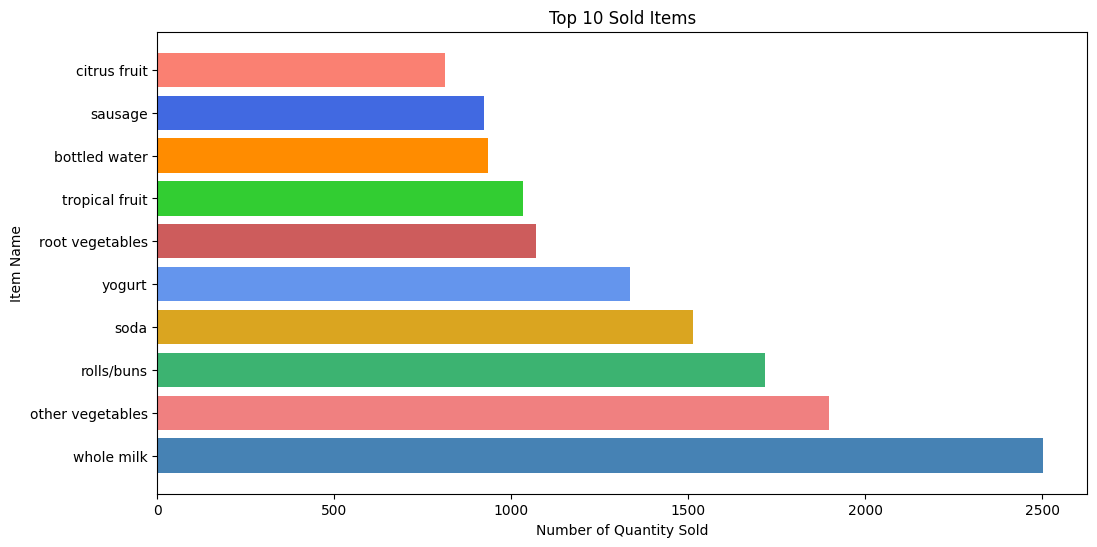

In [8]:
bars = item_distribution["itemDescription"]
height = item_distribution["Frequency"]
x_pos = np.arange(len(bars))
colors = ['steelblue', 'lightcoral', 'mediumseagreen', 'goldenrod', 'cornflowerblue',
          'indianred', 'limegreen', 'darkorange', 'royalblue', 'salmon']

plt.figure(figsize=(12, 6))
plt.barh(x_pos, height, color=colors)
plt.title("Top 10 Sold Items")
plt.xlabel("Number of Quantity Sold")
plt.ylabel("Item Name")
plt.yticks(x_pos, bars)
plt.show()

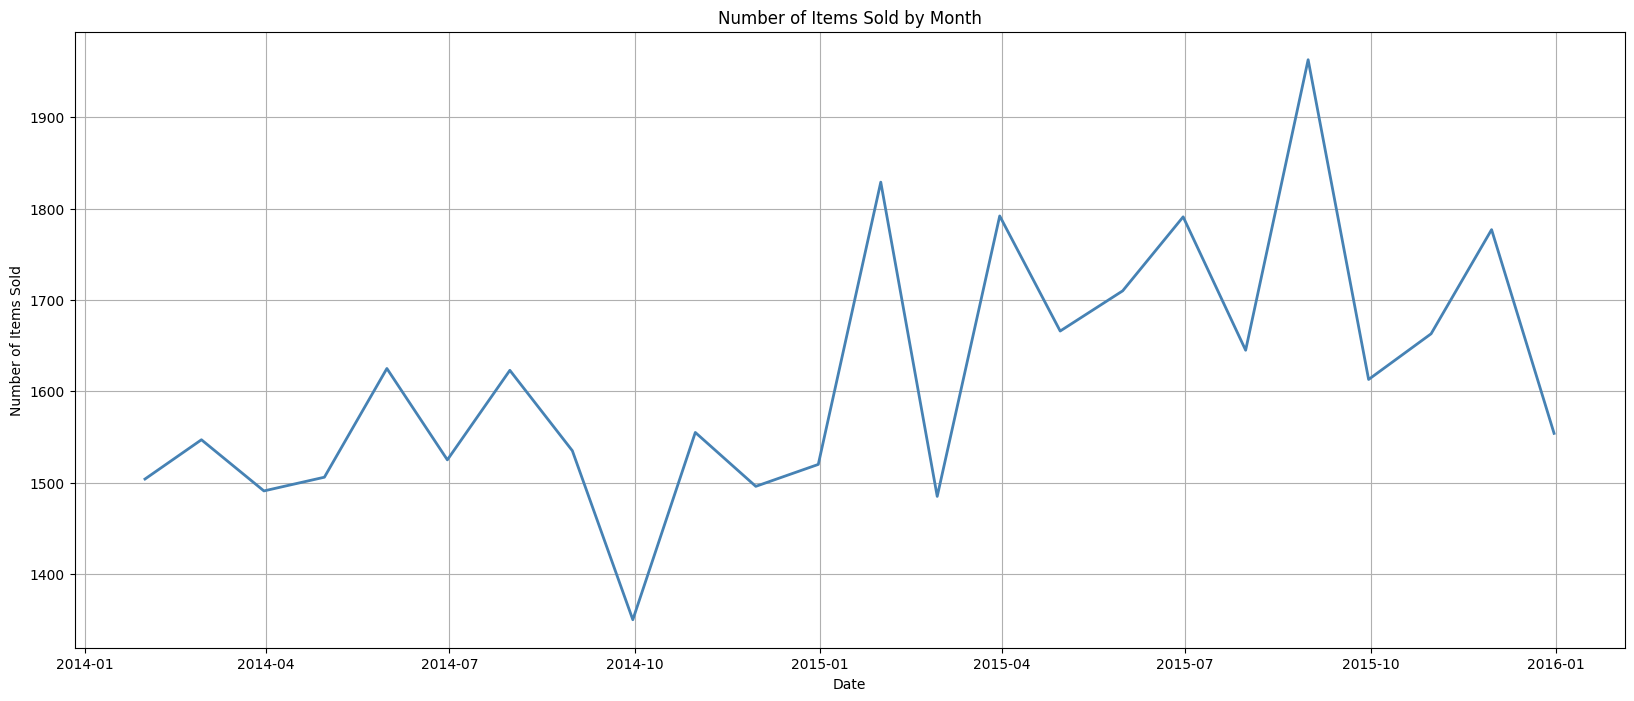

<ipython-input-9-4bd941b31567>:13: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  transactions = [a[1]['itemDescription'].tolist() for a in list(customer_level.groupby(['Member_number']))]


In [9]:
item_count_by_month = grocery_df.set_index('Date').resample("M")['itemDescription'].count()

plt.figure(figsize=(20, 8))
plt.plot(item_count_by_month.index, item_count_by_month.values, color='steelblue', linewidth=2)
plt.title("Number of Items Sold by Month")
plt.xlabel("Date")
plt.ylabel("Number of Items Sold")
plt.grid(True)
plt.show()

customer_level = grocery_df[["Member_number", "itemDescription"]].sort_values(by="Member_number", ascending=False)
customer_level['itemDescription'] = customer_level['itemDescription'].str.strip()
transactions = [a[1]['itemDescription'].tolist() for a in list(customer_level.groupby(['Member_number']))]

In [10]:
from apyori import apriori

min_support = 0.002
min_confidence = 0.05
min_lift = 3
min_length = 2
max_length = 2
  
association_rules = apriori(transactions=transactions, 
                            min_support=min_support, 
                            min_confidence=min_confidence, 
                            min_lift=min_lift, 
                            min_length=min_length, 
                            max_length=max_length)

results = list(association_rules)

In [11]:
def inspect(association_results):
    lhs = [tuple(result[2][0][0])[0] for result in association_results]
    rhs = [tuple(result[2][0][1])[0] for result in association_results]
    supports = [result[1] for result in association_results]
    confidences = [result[2][0][2] for result in association_results]
    lifts = [result[2][0][3] for result in association_results]
    return list(zip(lhs, rhs, supports, confidences, lifts))

results_df = pd.DataFrame(inspect(results), columns=['Left Hand Side', 'Right Hand Side', 'Support', 'Confidence', 'Lift'])
top_results = results_df.nlargest(n=10, columns="Lift")


In [12]:
top_results

,Left Hand Side,Right Hand Side,Support,Confidence,Lift
0,kitchen towels,UHT-milk,0.002309,0.300000,3.821569
1,potato products,beef,0.002565,0.454545,3.802185
2,canned fruit,coffee,0.002309,0.428571,3.728954
4,flour,mayonnaise,0.002309,0.063380,3.338599
6,sparkling wine,waffles,0.002565,0.217391,3.150154
5,rice,napkins,0.003079,0.244898,3.011395
3,meat spreads,domestic eggs,0.003592,0.400000,3.004239


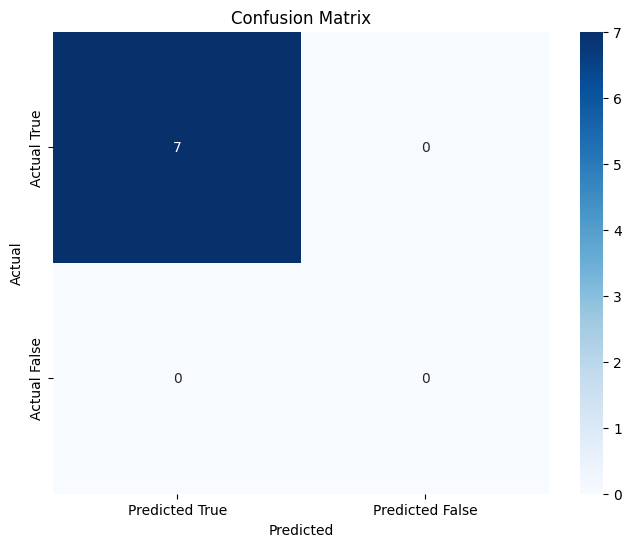

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the ground truth rules
ground_truth_rules = pd.DataFrame({
    'Left Hand Side': ['kitchen towels', 'potato products', 'canned fruit', 'flour', 'sparkling wine', 'rice', 'meat spreads'],
    'Right Hand Side': ['UHT-milk', 'beef', 'coffee', 'mayonnaise', 'waffles', 'napkins', 'domestic eggs']
})

# Define the discovered rules
discovered_rules = pd.DataFrame({
    'Left Hand Side': ['kitchen towels', 'potato products', 'canned fruit', 'flour', 'sparkling wine', 'rice', 'meat spreads'],
    'Right Hand Side': ['UHT-milk', 'beef', 'coffee', 'mayonnaise', 'waffles', 'napkins', 'domestic eggs']
})

# Convert ground truth rules and discovered rules to sets
ground_truth_rules_set = set(tuple(x) for x in ground_truth_rules[['Left Hand Side', 'Right Hand Side']].values)
discovered_rules_set = set(tuple(x) for x in discovered_rules[['Left Hand Side', 'Right Hand Side']].values)

# Calculate true positives
true_positives = len(ground_truth_rules_set.intersection(discovered_rules_set))

# Calculate false positives
false_positives = len(discovered_rules_set.difference(ground_truth_rules_set))

# Calculate false negatives
false_negatives = len(ground_truth_rules_set.difference(discovered_rules_set))

# Calculate true negatives
total_rules = len(ground_truth_rules_set.union(discovered_rules_set))
true_negatives = total_rules - (true_positives + false_positives + false_negatives)

# Create a confusion matrix
cm = pd.DataFrame(
    [[true_positives, false_positives], [false_negatives, true_negatives]],
    index=['Actual True', 'Actual False'],
    columns=['Predicted True', 'Predicted False']
)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [15]:
# Calculate accuracy
accuracy = true_positives / (true_positives + false_positives + false_negatives)
print("Accuracy:", accuracy * 100, "%")

Accuracy: 100.0 %


In [16]:
# Read the dataset
data = pd.DataFrame({
    'Left Hand Side': ['kitchen towels', 'potato products', 'canned fruit', 'flour', 'sparkling wine', 'rice', 'meat spreads'],
    'Right Hand Side': ['UHT-milk', 'beef', 'coffee', 'mayonnaise', 'waffles', 'napkins', 'domestic eggs'],
    'Support': [0.002309, 0.002565, 0.002309, 0.002309, 0.002565, 0.003079, 0.003592],
    'Confidence': [0.300000, 0.454545, 0.428571, 0.063380, 0.217391, 0.244898, 0.400000],
    'Lift': [3.821569, 3.802185, 3.728954, 3.338599, 3.150154, 3.011395, 3.004239]
})

In [17]:

#     
summary_stats = data.describe()
print("Summary Statistics:")
print(summary_stats)

Summary Statistics:
        Support  Confidence      Lift
count  7.000000    7.000000  7.000000
mean   0.002675    0.301255  3.408156
std    0.000488    0.139196  0.369922
min    0.002309    0.063380  3.004239
25%    0.002309    0.231145  3.080774
50%    0.002565    0.300000  3.338599
75%    0.002822    0.414285  3.765569
max    0.003592    0.454545  3.821569


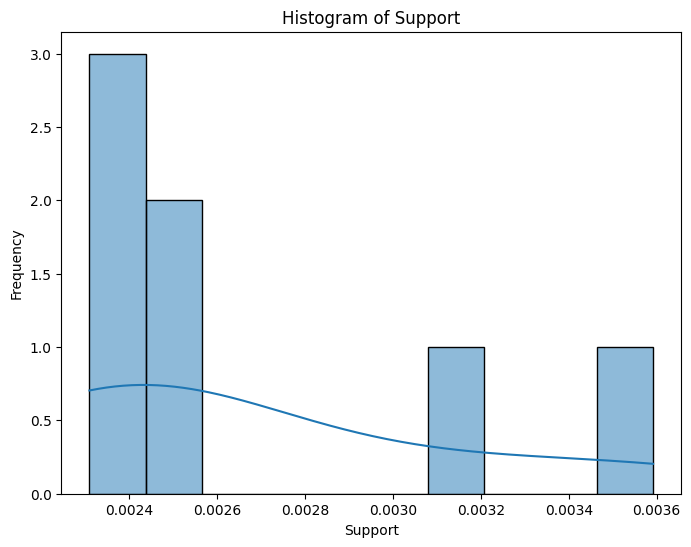

In [18]:
#   
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='Support', bins=10, kde=True)
plt.title("Histogram of Support")
plt.xlabel("Support")
plt.ylabel("Frequency")
plt.show()

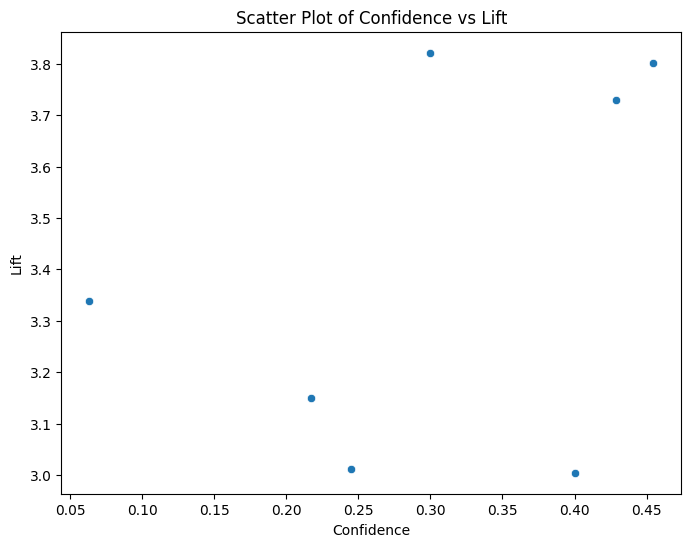

In [19]:
#   
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='Confidence', y='Lift')
plt.title("Scatter Plot of Confidence vs Lift")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.show()


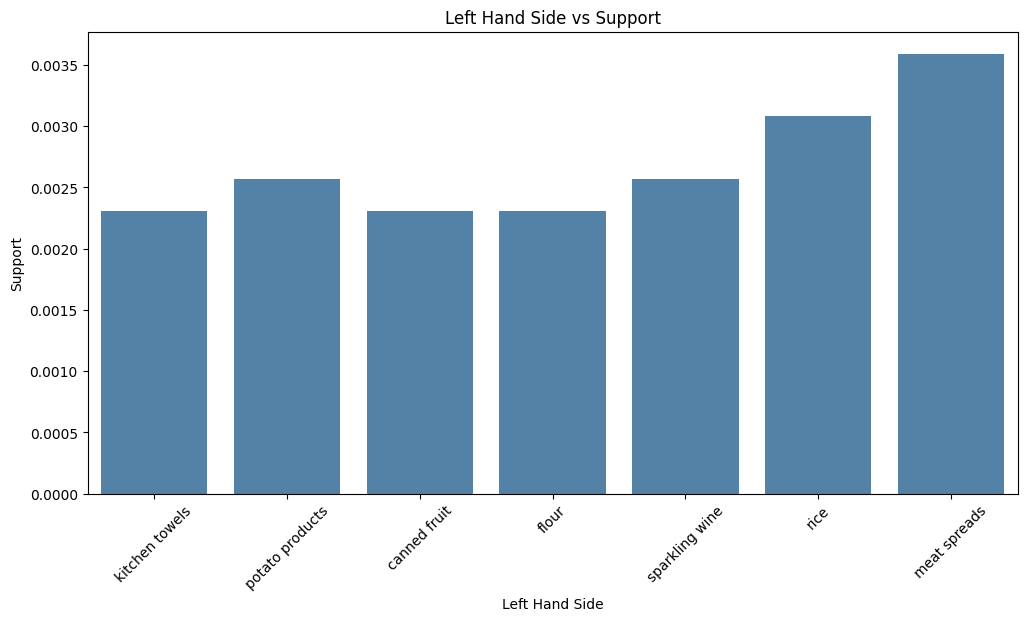

In [20]:
# Bar plot of Left Hand Side vs Support
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='Left Hand Side', y='Support', color='steelblue')
plt.title("Left Hand Side vs Support")
plt.xlabel("Left Hand Side")
plt.ylabel("Support")
plt.xticks(rotation=45)
plt.show()

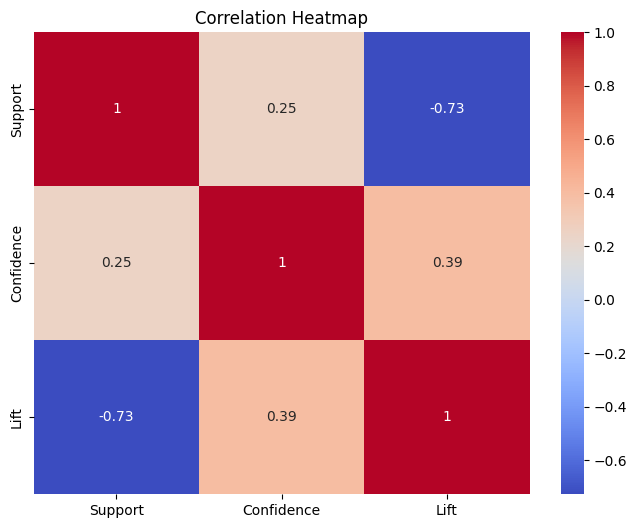

In [21]:

# Heatmap of Correlation
plt.figure(figsize=(8, 6))
corr_matrix = data[['Support', 'Confidence', 'Lift']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()